<a href="https://colab.research.google.com/github/machiwao/CCTHESS1-CCTHESS2-Dev-and-Docs/blob/eco/ToDrive_NDBI_data_scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install earthengine-api geemap scipy

In [2]:
import ee
import geemap
import pandas as pd
from scipy.signal import savgol_filter
import os

In [3]:
cloud_project = 'midyear-forest-427007-s7'

try:
  ee.Initialize(project=cloud_project)
except:
  ee.Authenticate()
  ee.Initialize(project=cloud_project)

stations = {
    "PortArea": ee.Geometry.Point([120.967866, 14.58841]).buffer(25000),
    "ScienceGarden": ee.Geometry.Point([121.044282, 14.645072]).buffer(25000),
    "SangleyPoint": ee.Geometry.Point([120.906838, 14.494953]).buffer(25000),
    "PuertoPrinsesa": ee.Geometry.Point([118.758613, 9.740134]).buffer(25000),
    "SanJose": ee.Geometry.Point([121.04788, 12.359602]).buffer(25000),
}

start_date = "2014-01-01"
end_date   = "2024-01-01"


In [4]:
def get_hls_collection(region, start_date, end_date):
    # Landsat HLS
    hls_landsat = (
        ee.ImageCollection("NASA/HLS/HLSL30/v002")
        .filterBounds(region)
        .filterDate(start_date, end_date)
        .map(lambda img: img.select(["B5", "B6"])  # B05 = NIR, B06 = SWIR1
                         .multiply(0.0001)           # scale factor
                         .copyProperties(img, img.propertyNames()))
    )

    # Sentinel-2 HLS
    hls_sentinel = (
        ee.ImageCollection("NASA/HLS/HLSS30/v002")
        .filterBounds(region)
        .filterDate(start_date, end_date)
        .map(lambda img: img.select(["B8A", "B11"])  # B8A = NIR, B11 = SWIR1
                         .multiply(0.0001)
                         .rename(["B5", "B6"])     # rename to match Landsat
                         .copyProperties(img, img.propertyNames()))
    )

    # Merge both collections
    merged = hls_landsat.merge(hls_sentinel)

    # Compute NDBI = (SWIR - NIR) / (SWIR + NIR)
    def add_ndbi(img):
        ndbi = img.expression(
            "(SWIR - NIR) / (SWIR + NIR)",
            {"SWIR": img.select("B6"), "NIR": img.select("B5")}
        ).rename("NDBI")
        return img.addBands(ndbi).select("NDBI")

    return merged.map(add_ndbi)

In [5]:
def process_station(station_name, geometry, start_date, end_date):
    hls = get_hls_collection(geometry, start_date, end_date)

    print(f"Processing NDBI for {station_name}...")

    ts = hls.map(lambda img: ee.Feature(
        None, {
            "date": img.date().format("YYYY-MM-dd"),
            "NDBI": img.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geometry,
                scale=30,
                bestEffort=True,
                maxPixels=1e9
            ).get("NDBI")
        }
    ))

    df = geemap.ee_to_df(ee.FeatureCollection(ts))

    if df.empty:
        print(f"No data for {station_name}")
        return df

    # Process time series
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").groupby("date").mean().reset_index()

    # Reindex to daily
    full_range = pd.date_range(start=start_date, end=end_date, freq="D")
    g = df.set_index("date").reindex(full_range)
    g.index.name = "date"
    g = g.reset_index()

    # Preserve original values
    g["NDBI_original"] = g["NDBI"]

    # Interpolate missing values only (keeping original intact)
    g["NDBI_linear"] = g["NDBI"].interpolate("linear", limit_direction="both")
    g["NDBI_spline"] = g["NDBI"].interpolate("spline", order=3, limit_direction="both")

    # Save to CSV: include original, interpolated, and smooth
    out_file = f"{station_name}_NDBI.csv"
    g[["date", "NDBI_original", "NDBI_linear", "NDBI_spline"]].to_csv(out_file, index=False)

    print(f"Saved {out_file} ({g.shape[0]} rows)")
    return g

In [6]:
all_dfs = {}
for station, geom in stations.items():
    all_dfs[station] = process_station(station, geom, start_date, end_date)

Processing NDBI for PortArea...
Saved PortArea_NDBI.csv (3653 rows)
Processing NDBI for ScienceGarden...
Saved ScienceGarden_NDBI.csv (3653 rows)
Processing NDBI for SangleyPoint...
Saved SangleyPoint_NDBI.csv (3653 rows)
Processing NDBI for PuertoPrinsesa...
Saved PuertoPrinsesa_NDBI.csv (3653 rows)
Processing NDBI for SanJose...
Saved SanJose_NDBI.csv (3653 rows)


In [7]:
# Check the first few rows of one of the dataframes
if all_dfs:
    first_station = list(all_dfs.keys())[0]
    print(f"First values for {first_station}:")
    display(all_dfs[first_station].head())
else:
    print("No dataframes were processed.")

First values for PortArea:


,date,NDBI,NDBI_original,NDBI_linear,NDBI_spline
0,2014-01-01,NaN,NaN,0.006647,0.096477
1,2014-01-02,NaN,NaN,0.006647,0.096280
2,2014-01-03,NaN,NaN,0.006647,0.096083
3,2014-01-04,NaN,NaN,0.006647,0.095887
4,2014-01-05,NaN,NaN,0.006647,0.095691


Mounted at /content/drive
Processing existing NDBI CSV files and copying to Google Drive...
CSV saved to Google Drive: /content/drive/MyDrive/Jerico_Datasets/NDBI/PortArea_NDBI.csv
Plot saved to Google Drive: /content/drive/MyDrive/Jerico_Datasets/NDBI/PortArea_NDBI_plot.png


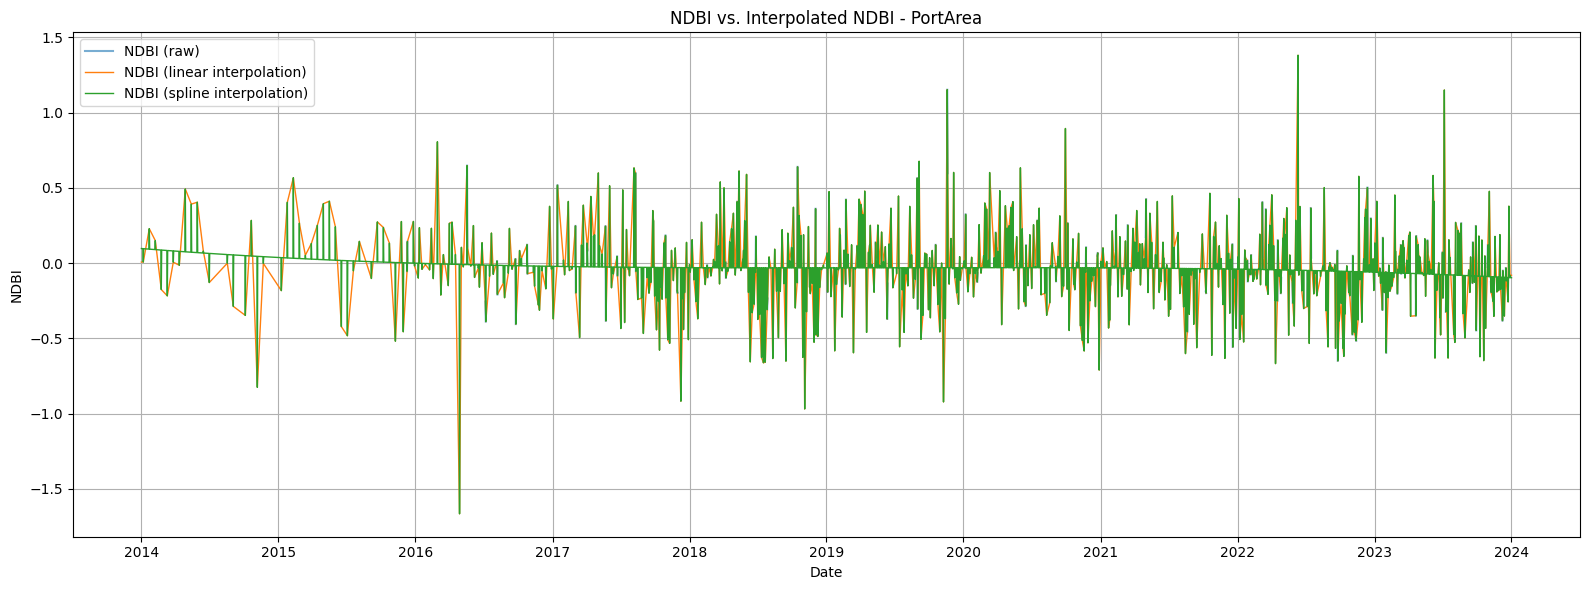

CSV saved to Google Drive: /content/drive/MyDrive/Jerico_Datasets/NDBI/ScienceGarden_NDBI.csv
Plot saved to Google Drive: /content/drive/MyDrive/Jerico_Datasets/NDBI/ScienceGarden_NDBI_plot.png


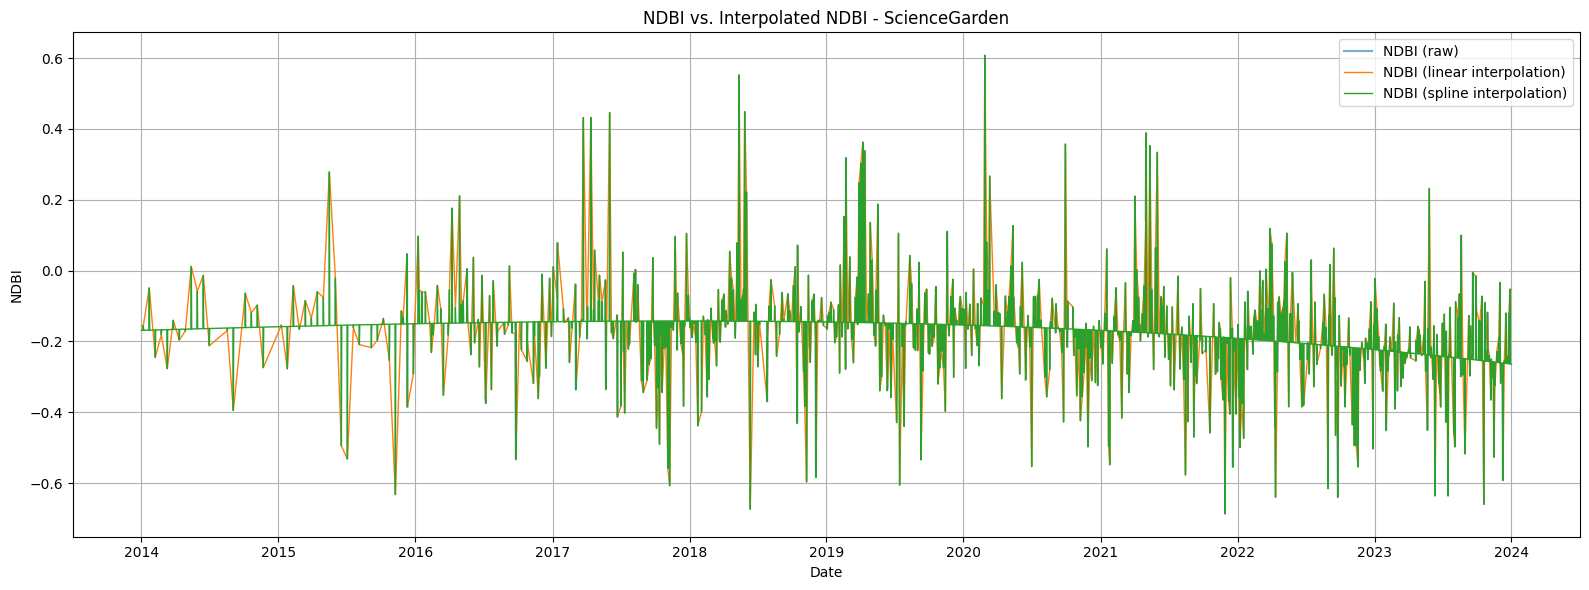

CSV saved to Google Drive: /content/drive/MyDrive/Jerico_Datasets/NDBI/SangleyPoint_NDBI.csv
Plot saved to Google Drive: /content/drive/MyDrive/Jerico_Datasets/NDBI/SangleyPoint_NDBI_plot.png


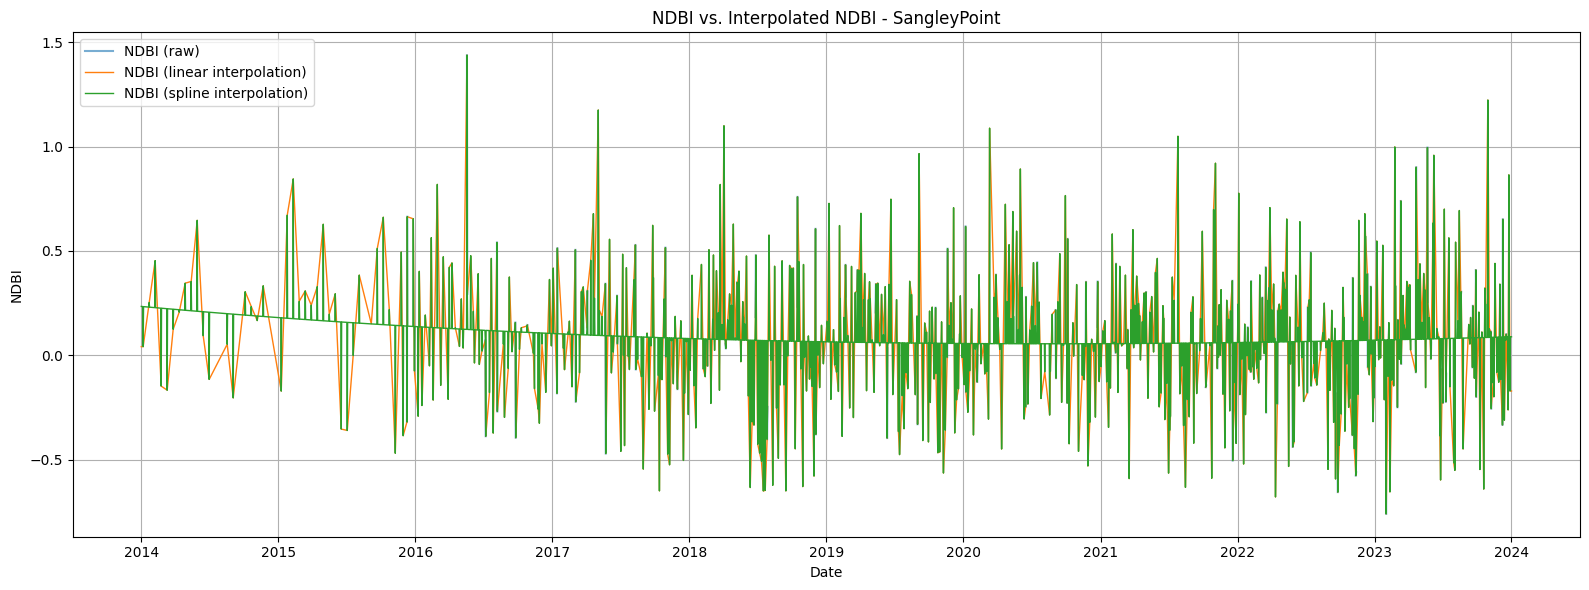

CSV saved to Google Drive: /content/drive/MyDrive/Jerico_Datasets/NDBI/PuertoPrinsesa_NDBI.csv
Plot saved to Google Drive: /content/drive/MyDrive/Jerico_Datasets/NDBI/PuertoPrinsesa_NDBI_plot.png


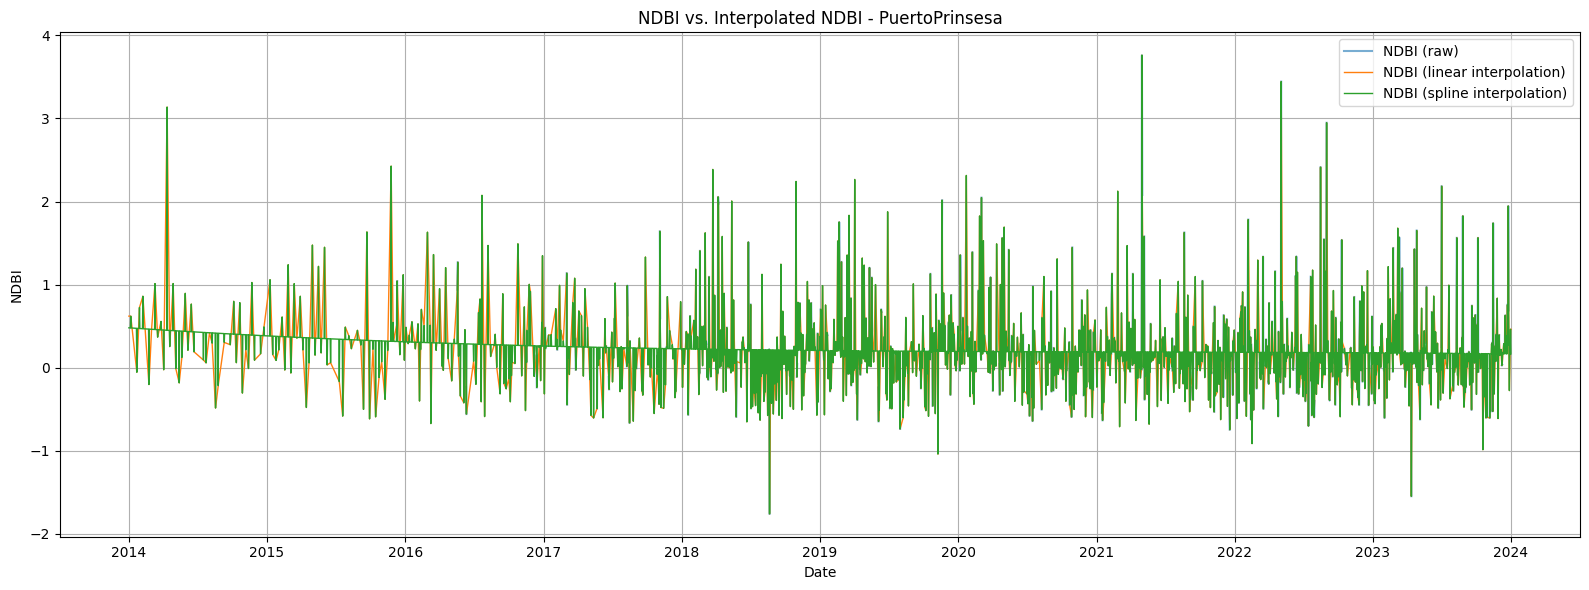

CSV saved to Google Drive: /content/drive/MyDrive/Jerico_Datasets/NDBI/SanJose_NDBI.csv
Plot saved to Google Drive: /content/drive/MyDrive/Jerico_Datasets/NDBI/SanJose_NDBI_plot.png


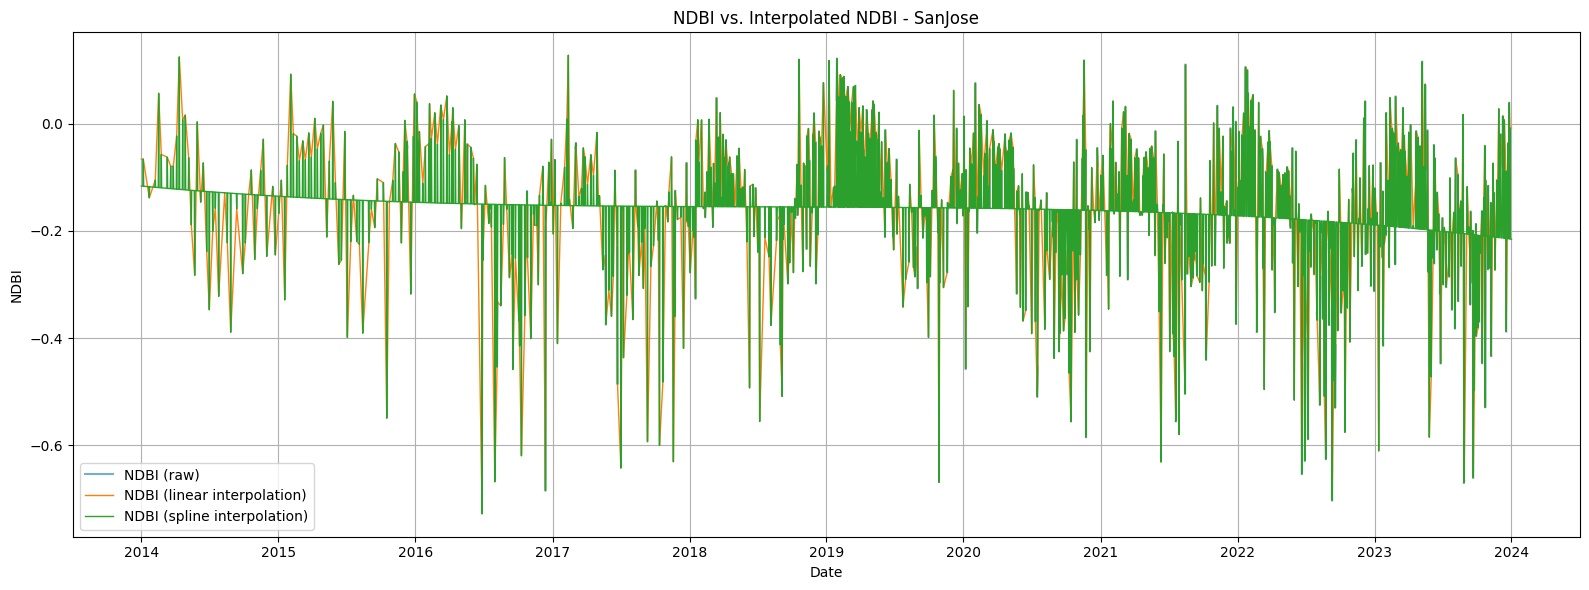


Google Drive folder created at: /content/drive/MyDrive/Jerico_Datasets/NDBI
You can now access your NDBI CSV files from Google Drive even after the Colab session ends!

Files in Google Drive folder:
  - PortArea_NDBI.csv
  - PortArea_NDBI_plot.png
  - ScienceGarden_NDBI.csv
  - ScienceGarden_NDBI_plot.png
  - SangleyPoint_NDBI.csv
  - SangleyPoint_NDBI_plot.png
  - PuertoPrinsesa_NDBI.csv
  - PuertoPrinsesa_NDBI_plot.png
  - SanJose_NDBI.csv
  - SanJose_NDBI_plot.png

Alternative combined folder available at: /content/drive/MyDrive/Environmental_Data/
You can modify the 'gdrive_folder' variable to use this path if you want all data in one place.


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the Google Drive folder path where you want to save CSV files
# Modify this path to match your desired folder structure
gdrive_folder = '/content/drive/MyDrive/Jerico_Datasets/NDBI'  # Change this path as needed

# Create the folder if it doesn't exist
os.makedirs(gdrive_folder, exist_ok=True)

def plot_values(csv_file, station_name, save_to_gdrive=True):
    """
    Plot NDBI values and optionally save/copy CSV to Google Drive

    Args:
        csv_file: Path to the CSV file in Colab
        station_name: Name of the station
        save_to_gdrive: Whether to copy the CSV to Google Drive
    """
    # Load CSV (expects columns: date, NDBI_original, NDBI_linear, NDBI_spline)
    df = pd.read_csv(csv_file, parse_dates=["date"])

    # Copy CSV to Google Drive if requested
    if save_to_gdrive:
        gdrive_csv_path = os.path.join(gdrive_folder, csv_file)
        df.to_csv(gdrive_csv_path, index=False)
        print(f"CSV saved to Google Drive: {gdrive_csv_path}")

    # Plot
    plt.figure(figsize=(16, 6))
    plt.plot(df["date"], df["NDBI_original"], label="NDBI (raw)", alpha=0.6)
    plt.plot(df["date"], df["NDBI_linear"], label="NDBI (linear interpolation)", linewidth=1)
    plt.plot(df["date"], df["NDBI_spline"], label="NDBI (spline interpolation)", linewidth=1)

    plt.xlabel("Date")
    plt.ylabel("NDBI")
    plt.title(f"NDBI vs. Interpolated NDBI - {station_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Optionally save the plot to Google Drive as well
    if save_to_gdrive:
        plot_filename = f"{station_name}_NDBI_plot.png"
        plot_path = os.path.join(gdrive_folder, plot_filename)
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to Google Drive: {plot_path}")

    plt.show()

# Alternative function to work directly with Google Drive paths
def create_and_save_ndbi_csv_to_gdrive(data, filename, station_name):
    """
    Create an NDBI CSV from data and save directly to Google Drive

    Args:
        data: DataFrame or data to save
        filename: Name of the CSV file
        station_name: Station name for the plot
    """
    # Save directly to Google Drive
    gdrive_csv_path = os.path.join(gdrive_folder, filename)

    if isinstance(data, pd.DataFrame):
        data.to_csv(gdrive_csv_path, index=False)
    else:
        # If data is not a DataFrame, convert it
        df = pd.DataFrame(data)
        df.to_csv(gdrive_csv_path, index=False)

    print(f"NDBI CSV created and saved to Google Drive: {gdrive_csv_path}")
    return gdrive_csv_path

def plot_values_from_gdrive(gdrive_csv_path, station_name):
    """
    Plot NDBI values directly from Google Drive CSV file
    """
    df = pd.read_csv(gdrive_csv_path, parse_dates=["date"])

    plt.figure(figsize=(16, 6))
    plt.plot(df["date"], df["NDBI_original"], label="NDBI (raw)", alpha=0.6)
    plt.plot(df["date"], df["NDBI_linear"], label="NDBI (linear interpolation)", linewidth=1)
    plt.plot(df["date"], df["NDBI_spline"], label="NDBI (spline interpolation)", linewidth=1)

    plt.xlabel("Date")
    plt.ylabel("NDBI")
    plt.title(f"NDBI vs. Interpolated NDBI - {station_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def process_and_save_ndbi_station_data(station_data, station_name):
    """
    Example function showing how to process NDBI data and save directly to Google Drive

    Args:
        station_data: Your processed NDBI data (DataFrame)
        station_name: Name of the station
    """
    # Process your data here (interpolation, etc.)
    # This is just an example - replace with your actual data processing

    # Save directly to Google Drive
    csv_filename = f"{station_name}_NDBI.csv"
    gdrive_csv_path = os.path.join(gdrive_folder, csv_filename)

    station_data.to_csv(gdrive_csv_path, index=False)
    print(f"Processed NDBI data saved to Google Drive: {gdrive_csv_path}")

    # Plot using the Google Drive file
    plot_values_from_gdrive(gdrive_csv_path, station_name)

# Method 1: Process existing CSV files and copy them to Google Drive
station_names = ["PortArea", "ScienceGarden", "SangleyPoint", "PuertoPrinsesa", "SanJose"]

print("Processing existing NDBI CSV files and copying to Google Drive...")
for station in station_names:
    csv_file = f"{station}_NDBI.csv"
    if os.path.exists(csv_file):  # Check if file exists in Colab
        plot_values(csv_file, station, save_to_gdrive=True)
    else:
        print(f"Warning: {csv_file} not found in Colab directory")

print(f"\nGoogle Drive folder created at: {gdrive_folder}")
print("You can now access your NDBI CSV files from Google Drive even after the Colab session ends!")

# Optional: List files in Google Drive folder
print(f"\nFiles in Google Drive folder:")
if os.path.exists(gdrive_folder):
    for file in os.listdir(gdrive_folder):
        print(f"  - {file}")
else:
    print("  No files yet - run the processing functions above")